In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 30
BS = 16

In [3]:
#dataset path
DIRECTORY = r"C:\Users\CARNIVAL\OneDrive\سطح المكتب\dataset"
CATEGORIES = ["alpaca", "not alpaca"]

In [4]:
#load dataset(two classes imgs)
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [5]:
print("we have :",len(data),"imgs")

we have : 327 imgs


In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [7]:
for label in labels:
    print(label)

[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]


In [8]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)


In [9]:

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 [==============================] - 6s 1us/step


In [11]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
#headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [12]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
        layer.trainable = False


In [14]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


E:\programes\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/30
16/16 [==============================] - 18s 775ms/step - loss: 0.7368 - accuracy: 0.7633 - val_loss: 0.1617 - val_accuracy: 0.9394
Epoch 2/30
16/16 [==============================] - 10s 651ms/step - loss: 0.3783 - accuracy: 0.8816 - val_loss: 0.1330 - val_accuracy: 0.9394
Epoch 3/30
16/16 [==============================] - 10s 653ms/step - loss: 0.2267 - accuracy: 0.9347 - val_loss: 0.1289 - val_accuracy: 0.9394
Epoch 4/30
16/16 [==============================] - 11s 668ms/step - loss: 0.2729 - accuracy: 0.9020 - val_loss: 0.1083 - val_accuracy: 0.9848
Epoch 5/30
16/16 [==============================] - 11s 652ms/step - loss: 0.2298 - accuracy: 0.9265 - val_loss: 0.0883 - val_accuracy: 0.9848
Epoch 6/30
16/16 [==============================] - 11s 660ms/step - loss: 0.1409 - accuracy: 0.9633 - val_loss: 0.0990 - val_accuracy: 0.9697
Epoch 7/30
16/16 [==============================] - 10s 647ms/step - loss: 0.1118 - accuracy: 0.9755 - val_loss: 0.096

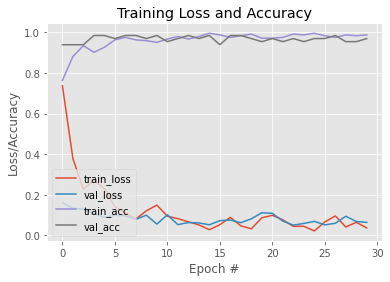

In [16]:
# plot the training loss and accuracy
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [17]:
predIdxs = model.predict(testX, batch_size=BS)

5/5 [==============================] - 3s 348ms/step


In [18]:
predIdxs = np.argmax(predIdxs, axis=1)


In [19]:
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

      alpaca       1.00      0.93      0.96        29
  not alpaca       0.95      1.00      0.97        37

    accuracy                           0.97        66
   macro avg       0.97      0.97      0.97        66
weighted avg       0.97      0.97      0.97        66



In [20]:
print("[INFO] saving mask detector model...")
model.save("mobilnet.model", save_format="h5")

[INFO] saving mask detector model...


In [21]:
y_pred = model.predict(testX)

print('Prediction Shape is {}'.format(y_pred.shape))

3/3 [==============================] - 2s 448ms/step
Prediction Shape is (66, 2)


In [22]:
code = {'alpaca':0 ,'not alpaca':1}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

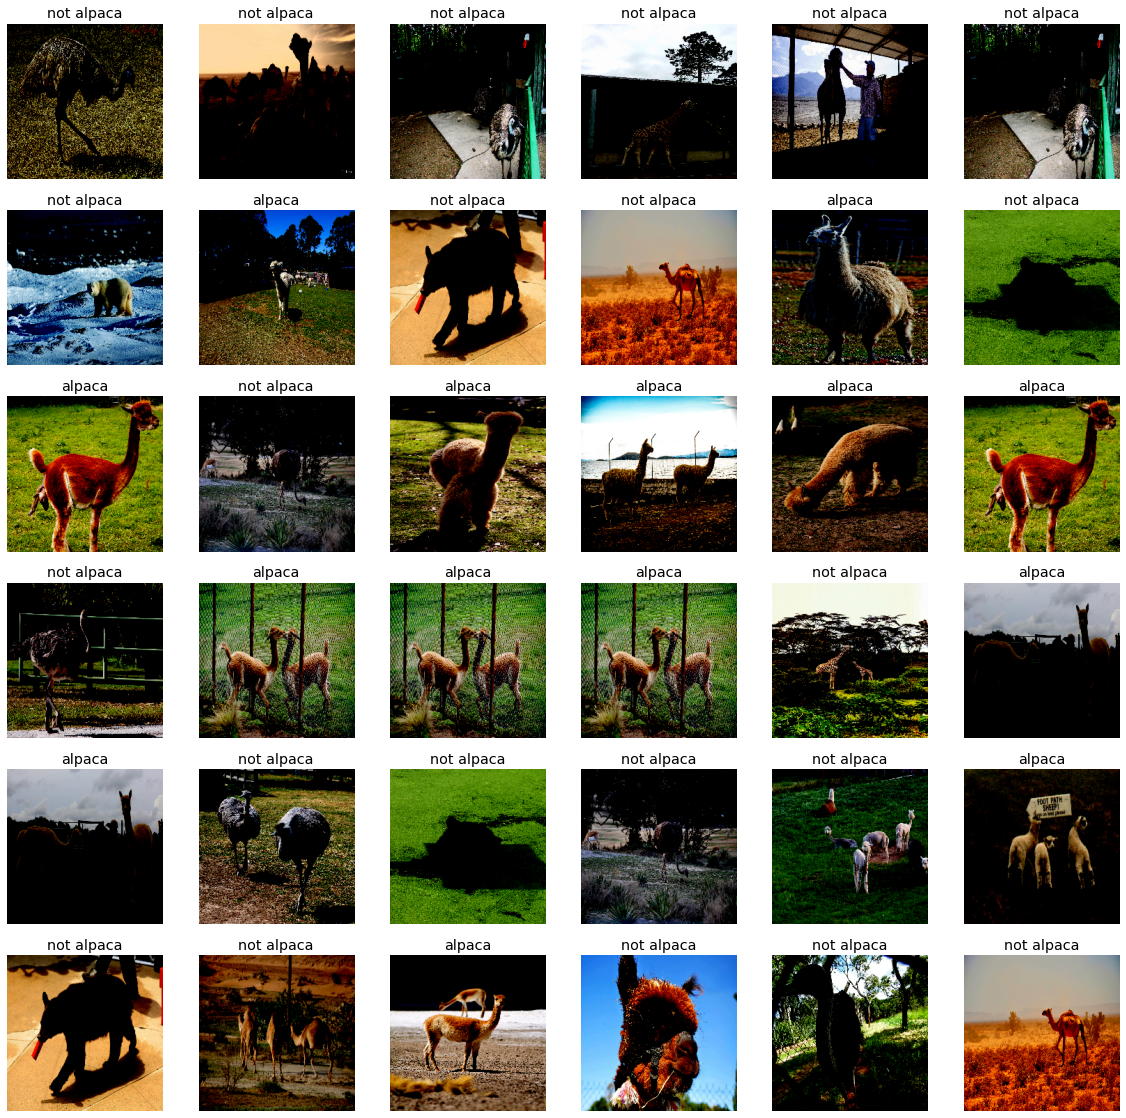

In [23]:

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(testX),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(testX[i])    
    plt.axis('off')
    plt.title(getcode(np.argmax(y_pred[i])))